In [9]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [394]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)

In [821]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [824]:
%%R

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
sample_data(ps.merged)
# Cleaning up the sample data table
physeq = ps.merged

In [836]:
%%R
head(sample_data(physeq))

Sample Data:        [6 samples by 3 sample variables]:
         Cosm Month        Trtmt
B__        NA    NA        Blank
F_2_15     15   2.0 Ferrihydrite
F_2_28     28   2.0 Ferrihydrite
F_2_33     33   2.0 Ferrihydrite
F_2_9       9   2.0 Ferrihydrite
F_2.5_13   13   2.5 Ferrihydrite


In [829]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::summarize(total=n())
sample.data
# Find out how many of each treatment-month combination we have... 
# Don't want to run it on anything with just one or two samples

Source: local data frame [13 x 3]
Groups: Trtmt

            Trtmt Month total
1           Blank    NA     1
2    Ferrihydrite   2.0     4
3    Ferrihydrite   2.5     9
4    Ferrihydrite   3.0     5
5  Heavy Fraction   2.5     3
6       Kaolinite   2.5     8
7       Kaolinite   3.0     5
8          Quartz   2.0     1
9          Quartz   2.5     9
10         Quartz   3.0     5
11           Soil   2.0     5
12           Soil   2.5     6
13           Soil   3.0     5


In [841]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Quartz","Ferrihydrite","Heavy Fraction","Kaolinite"),
                        Month = c(2, 2.5, 3))
variables<-variables[c(2,5,6,7,8,9,10,12),]
variables

            Trtmt Month
2    Ferrihydrite   2.0
5          Quartz   2.5
6    Ferrihydrite   2.5
7  Heavy Fraction   2.5
8       Kaolinite   2.5
9          Quartz   3.0
10   Ferrihydrite   3.0
12      Kaolinite   3.0


In [948]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt,Month){
    physeq.pruned <- prune_samples(((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == Trtmt)) | ((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == "Soil")),physeq)
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
    physeq.pruned = prune_samples(sample_sums(physeq.pruned)>200, physeq.pruned)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Soil")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Month = Month
    results$Trtmt = Trtmt
    results = data.frame(results$Month,results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Month","Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }
# Note: this function throws an error based on calculating the geometric mean for samples with very low OTU counts
# Thus, we added the prune_samples step above, removing any samples with fewer than X counts.

In [951]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [952]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

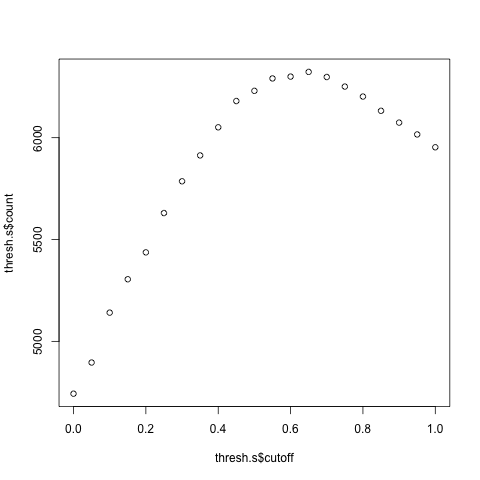

In [953]:
%%R
range = seq(0,1,0.05)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [954]:
%%R
filter(DA,baseMean>=0.65) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../../SeqData/l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [955]:
%%R
l2fc<-read.csv("../../SeqData/l2fc.csv")

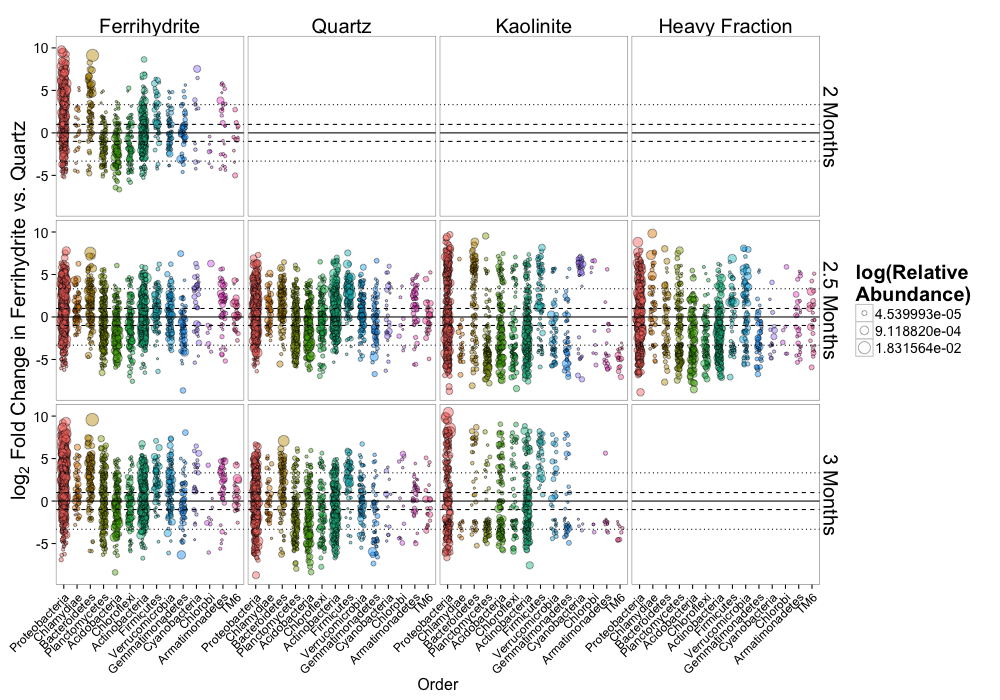

In [956]:
%%R -w 1000 -h 700
# setting the image sizes, then making the figure...

d = l2fc

d = group_by(d, Trtmt, Month) %>%
                mutate(relabund=baseMean/sum(baseMean))

N=50

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)    
   
d$MonthName = ifelse(d$Month==2,"2 Months",(ifelse(d$Month==2.5, "2.5 Months","3 Months")))
d$MonthName = paste(d$MonthName)
# Creates a "strip" column of d with Months

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
    
p = ggplot(d, aes(x = Phylum, y = l2FC, fill = Phylum, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~MonthName~Trtmt, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha=0.45, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Order")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change in Ferrihydrite vs. Quartz",sep="")))
# sets the label for the y axes.


#p = p + scale_color_continuous(trans="log")    
p = p + scale_fill_discrete(guide="none")
    
#colourCount = length(unique(d$Order))
#getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
#p = p + scale_colour_manual(values=getPalette(colourCount))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [985]:
%%R
d = l2fc%>%
    filter(Month==3 & Trtmt=="Ferrihydrite")
head(d[d$baseMean==order(d$baseMean),])

 [1] Month    Trtmt    OTU      baseMean l2FC     SE       pvalue   Kingdom 
 [9] Phylum   Class    Order    Family   Genus    Species  padj    
<0 rows> (or 0-length row.names)


In [1001]:
%%R
d = l2fc%>%
    filter(Month==3 & Trtmt=="Ferrihydrite")
d <- d[order(-d$baseMean),] 
head(d)

    Month        Trtmt      OTU  baseMean     l2FC        SE       pvalue
39      3 Ferrihydrite  13_1570 5146.3028 8.455169 1.9693576           NA
913     3 Ferrihydrite   28_165 4532.0500 9.578758 1.8309827           NA
609     3 Ferrihydrite  21_3993 1272.6019 2.750681 0.7800802           NA
650     3 Ferrihydrite 49_34182 1089.4088 7.331276 1.3992917           NA
730     3 Ferrihydrite  80_9723 1014.0808 4.544291 0.9261371 9.261433e-07
672     3 Ferrihydrite  44_4086  861.7163 6.404780 1.1745829 4.957937e-08
     Kingdom         Phylum               Class           Order
39  Bacteria Proteobacteria  Betaproteobacteria Burkholderiales
913 Bacteria  Bacteroidetes       [Saprospirae] [Saprospirales]
609 Bacteria Proteobacteria Alphaproteobacteria     Rhizobiales
650 Bacteria Proteobacteria Alphaproteobacteria     Rhizobiales
730 Bacteria Proteobacteria Alphaproteobacteria     Rhizobiales
672 Bacteria Proteobacteria Alphaproteobacteria Caulobacterales
               Family        Genus

In [1023]:
%%R

cutoff=2

d.high = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>cutoff)%>%
# Include only the rows where log2fold change is higher than 3, 
# We don't use the p value filter because we already filtered and it can't handle OTUs
# where some counts are 0
    dplyr::group_by(Trtmt,Month) %>%
# Then, treating each month and mineral separately,
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
# Create a new column called relabund, which is the mean normalized count, divided by the total
# (total of those we selected, not of the whole dataset). 
    dplyr::group_by(Trtmt,Month,Family) %>%
# Then, using this data, still grouped by month and mineral, we further group it by phylum,
    dplyr::summarise(relabund=sum(relabund))
# And we tally up all the relative counts for each taxonomic group.

colnames(d.high) <- c("Trtmt","Month","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high$Trtmt = ordered(d.high$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
# Order the treatments
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order

abund=0.01
d.high<-d.high %>%
    dplyr::filter(relabund>abund)
d.high$relabund
dim(d.high)

[1] 138   4


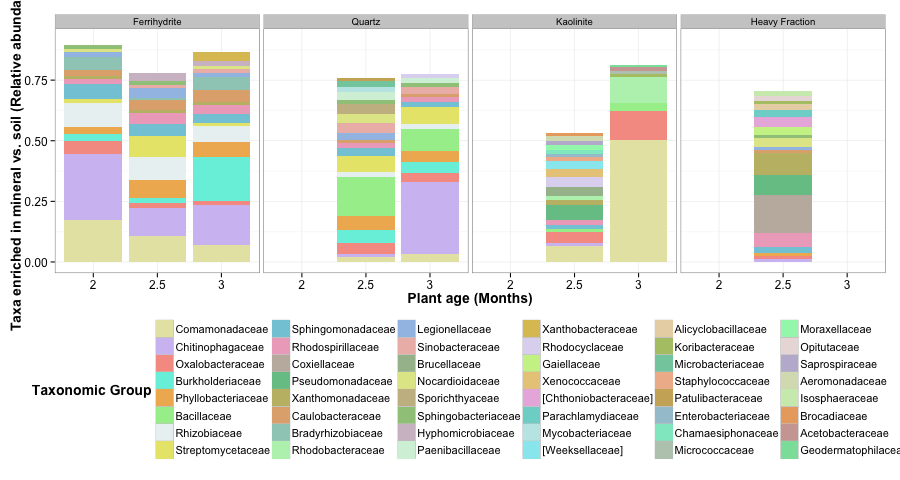

In [1024]:
%%R -w 900

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
d.plot$Month <- as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month,y=relabund,fill = Tax))

p = p + facet_grid(~Trtmt)

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Taxonomic Group", ncol = 6))

p = p + xlab("Plant age (Months)") + ylab("Taxa enriched in mineral vs. soil (Relative abundance)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11), legend.title=element_text(size=14), legend.position="bottom")

p

In [1004]:
%%R

cutoff = 3.3

d.OTU = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>cutoff)%>%
# Include only the rows where log2fold change is higher than 3.
    dplyr::group_by(Trtmt,Month) %>%
# Then, treating each month and mineral separately,
    dplyr::mutate(relabund=baseMean/sum(baseMean))

#colnames(d.high) <- c("Trtmt","Month","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.OTU, .(OTU), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.OTU$OTU = factor(d.OTU$OTU, levels=mean.Abund[order(-mean.Abund$M),]$OTU)
# Order the phyla by abundance
d.OTU<-d.OTU[with(d.OTU, order(OTU)),]
# Sort the whole dataframe by this order

In [1005]:
%%R
cutoff=0.01
d.OTU.common<-d.OTU %>%
    dplyr::filter(relabund>cutoff)
d.OTU.common$relabund
dim(d.OTU.common)

[1] 133  16


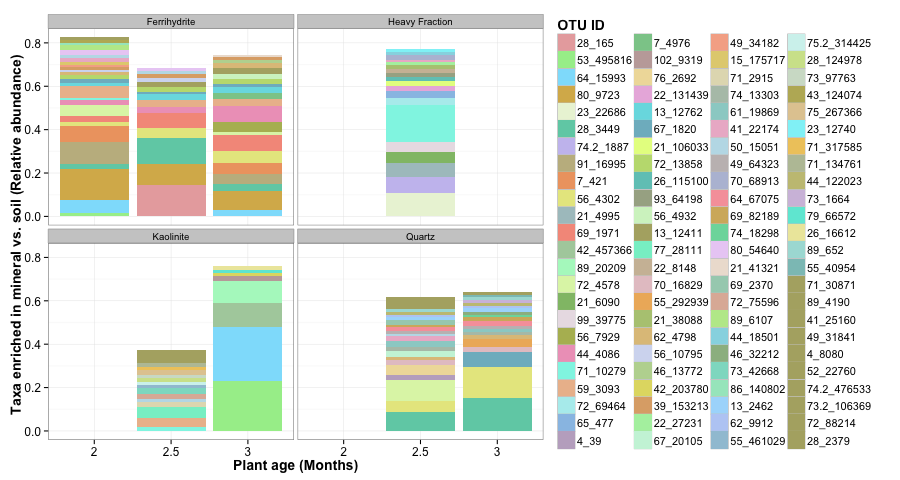

In [1000]:
%%R -w 900

d.plot = d.OTU.common

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$OTU)), color_space = hcl_presets$pastel)
d.plot$Month <- as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month,y=relabund,fill = OTU))

p = p + facet_wrap(~Trtmt)

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="OTU ID", ncol = 4))

p = p + xlab("Plant age (Months)") + ylab("Taxa enriched in mineral vs. soil (Relative abundance)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11))
p = p + theme(legend.title=element_text(size=14))

p

Chitinophaga (Saprospirae) - gliding behaviour - decompose fungi???  
Janthinobacterium (Burkholderia) - soil bacteria - violacein - anti-fungal properties  
Rhizobiales  
Paenebacillus - N fixer - affinity for low iron... (high in quartz)  
Candidatus Xiphinematobacter (the Chthonibacter) may be nematode endosymbiont! Nematode carries into HF! Bag mesh 18µm, nematodes can be 5µm in diameter.  
Prosthecobacter - Verrucomicrobia, oligotroph,  
Coxiellaceae(21_4995, 65_477, 22_8148)  

In [733]:
%%R
d.OTU.cox <- d.OTU %>%
    dplyr::filter(Family=="Coxiellaceae")
d.OTU.cox

Source: local data frame [6 x 16]
Groups: Trtmt, Month

  Month Trtmt       OTU   baseMean     l2FC       SE       pvalue  Kingdom
1   2.5     H   21_4995 157.021153 7.630627 1.115114 7.759975e-12 Bacteria
2   2.5     H    65_477  78.083987 5.949652 1.000246 2.711284e-09 Bacteria
3   2.5     H   22_8148  44.787439 5.501444 1.100002 5.694334e-07 Bacteria
4   2.5     H 21_812707  11.003194 7.108733 1.653185 1.707799e-05 Bacteria
5   2.5     H 23_176393   6.094303 5.561645 1.525898 2.675653e-04 Bacteria
6   2.0     F  4_238347   1.665087 5.921784 1.904212 1.871924e-03 Bacteria
Variables not shown: Phylum (fctr), Class (fctr), Order (fctr), Family (fctr),
  Genus (fctr), Species (fctr), padj (dbl), relabund (dbl)


In [675]:
%%R
d = data.frame(tax_table(physeq))
d.Sapro <- d[d$Family=="Coxiellaceae",]
d.Sapro <- d.Sapro[complete.cases(d.Sapro$Family),]
d.Sapro

              Kingdom         Phylum               Class         Order
39_72783     Bacteria Proteobacteria Gammaproteobacteria Legionellales
24_427616    Bacteria Proteobacteria Gammaproteobacteria Legionellales
76.2_830717  Bacteria Proteobacteria Gammaproteobacteria Legionellales
41_103662    Bacteria Proteobacteria Gammaproteobacteria Legionellales
70_24277     Bacteria Proteobacteria Gammaproteobacteria Legionellales
96_92201     Bacteria Proteobacteria Gammaproteobacteria Legionellales
95_26373     Bacteria Proteobacteria Gammaproteobacteria Legionellales
103_411545   Bacteria Proteobacteria Gammaproteobacteria Legionellales
92_520853    Bacteria Proteobacteria Gammaproteobacteria Legionellales
56_463647    Bacteria Proteobacteria Gammaproteobacteria Legionellales
28_1257896   Bacteria Proteobacteria Gammaproteobacteria Legionellales
104_920579   Bacteria Proteobacteria Gammaproteobacteria Legionellales
102_550470   Bacteria Proteobacteria Gammaproteobacteria Legionellales
23_126

In [587]:
%%R
otu_table(physeq)[c("28_165","49_597909","46_32212","96_43816")]

OTU Table:          [4 taxa and 102 samples]
                     taxa are rows
             1 67 67.2 74.2 102 58   50 53   56 52 95 39 69.2 104    49 41 76.2
28_165    1529  0    0  977  11 16 2839  1 8400  2  0  5    2   0 20242  3   11
49_597909    0  0    0  528   0  0    1  0   13  0  0  0    0   0   125  0    0
46_32212    11  0    2 3718   4  5   24  5   85  0  3  0    0   2   192  5   20
96_43816     0  2    3   10   0  0    0  0    3  2  1  0    0   2     0  5    0
          99 96 98 100 92 101 93 61  4 10 103 38 77.2  7 97   70 62 106  26 72
28_165    18  4  0  10  2  29  7 13 34  0   0  1    3 25  1 4287 92   8 128 87
49_597909  0  0  0   0  0   0  0  0  0  0   0  0    0  0  0    1  0   0   3  0
46_32212   0 20  1   3  0   8  3  3  4  2   2  0    5 23  1  112 27   6  17 94
96_43816   0  1  1   3  0  16  0  0  0  0  17  2    0 12  0    2  0   1   1  0
            74   44  19   13 21 15 23 22 94 76 70.2 64   65  59 43 80 79 17 29
28_165    6445 2578 621 6186  4 45  1  0  9 33

In [683]:
#Who is 
!grep -A 1 22_8148 ../../SeqData/otus.pick.fasta

>22_8148
GTGCCAGCAGCCGCGGTAATACAGAGGGTGCAAGCGTTAATCGGAGTTACTGGGCGTAAAGGGCGCGTAGGCGGATATTTAAGTTGGATGTGAAATCCCTGGGCTTAACCTAGGAATTGCATACAAAACTGGATATCTGGAGTACTGTAGAGGGTAGTGGAATTTCCGGTGTAGCGGTGAAATGCGTAGAGATCGGAAGGAACACCAGTGGCGAAGGCGGCTACCTGGACAGATACTGACGCTGAGGCGCGAGAGCGTGGGGAGCAAACAGGATTAGAAACCCGAGTAGTCC


Best hit for 28_165 was Chitinophaga ginsengisegetis strain Gsoil 040 (99% ID), does not degrade chitin  
For 46_32212 was Chitinophaga oryziterrae strain YC7001 (99% ID), does degrade chitin  
For 49_597909, was Chitinophaga arvensicola strain NBRC 14973, also niastenis and ginsengisegetis (all 99% ID)  
For 80_9723 - Rhizobium  
For 71_10279 - Pseudomonas ... (big in H minerals)  
For 91_16995 - Rhizobacter (big in F,2)  
Coxiellaceae:
For 21_4995 - Pseudomonas, Legionella only 91%
For 65_477 - Thalassotalea Profundimonas Alcanivorax Methylococcus, only 91%
For 22_8148 - Coxiella, Pseudomonas, only 91%

Maybe there are small differences between these OTUs and sequences that are ecologically relevant > use Oligotyping to separate?


In [797]:
%%R
Trtmt = c("A","A","A","A","A","A","B","B","B","B","B","B")
Month = c(1,1,1,2,2,2,1,1,1,2,2,2)
baseMean = c(3,2,1,3,2,3,1,2,4,2,3,1)
Phylum = c("Phylum1","Phylum1","Phylum2","Phylum1","Phylum2","Phylum2")
h=data.frame(Trtmt,Month,baseMean,Phylum)
# Testing to make sure I am calculating the relative abundances correctly (yes).
h

   Trtmt Month baseMean  Phylum
1      A     1        3 Phylum1
2      A     1        2 Phylum1
3      A     1        1 Phylum2
4      A     2        3 Phylum1
5      A     2        2 Phylum2
6      A     2        3 Phylum2
7      B     1        1 Phylum1
8      B     1        2 Phylum1
9      B     1        4 Phylum2
10     B     2        2 Phylum1
11     B     2        3 Phylum2
12     B     2        1 Phylum2


In [798]:
%%R
h.relabund = h %>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::group_by(Trtmt,Month,Phylum) %>%
# Then, using this data, still grouped by month, we further group it by phylum,
    dplyr::summarise(relabund=sum(relabund))
    
h.relabund

Source: local data frame [8 x 4]
Groups: Trtmt, Month

  Trtmt Month  Phylum  relabund
1     A     1 Phylum1 0.8333333
2     A     1 Phylum2 0.1666667
3     A     2 Phylum1 0.3750000
4     A     2 Phylum2 0.6250000
5     B     1 Phylum1 0.4285714
6     B     1 Phylum2 0.5714286
7     B     2 Phylum1 0.3333333
8     B     2 Phylum2 0.6666667
